# Gradients tutorial

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from catlearn.regression import GaussianProcess
np.random.seed(104)

This tutorial is intended to show that the resulting estimates are improved by including first derivative observations.

First we set up a known underlying function in one dimension. Then, we pick some values to train. Finally we will use CatLearn to make predictions on some unseen fingerprint and benchmark those predictions against the known underlying function.


### 1) Generate data.

We define a known underlying function in one dimension (y) and first derivative (dy).


In [30]:
def afunc(x):
    """Function (y) and first derivative (dy)."""
    y = 100 + (x-4) * np.sin(x)
    dy = (x-4) * np.cos(x) + np.sin(x)
    return [y, dy]

We select the number of training points. Each element in the list train can be referred to as a fingerprint.

In [31]:
train_points = 4 # Number of training points
train = 2*np.random.randn(train_points, 1) + 3.0 # Generate random points.
train = np.concatenate((train, [[0.0], [7.0]])) # Add two more training points.

Call the underlying function to produce the target values.


In [32]:
target = np.array(afunc(train)[0])
gradients = []
for i in train:
    gradients.append(afunc(i)[1])
gradients = np.asarray(gradients)

Generate test data (these are the points in which the user would obtain predictions from trained GP model)

In [33]:
test_points = 200 # Select the number test of points.
test = np.linspace(0.0, 7.0, test_points) # Interval of interest. 
test = np.reshape(test, (test_points, 1)) # The user must pass the test data as a 1D nparray.


### 2) Set up the parameters for the Gaussian Process.

Define initial prediction parameters.

In [34]:
reg = 0.1  # Regularisation parameter (SQE kernel).
scaling = 1.0  # Scaling parameter (SQE kernel).
w = 1.0  # Length scale parameter (SQE kernel).
c = 100.0 # Constant (constant kernel).

Select kernel. In this example we combine two kernels, by adding the square exponential kernel (SQE) with a constant kernel.

In [35]:
kdict = {'k1': {'type': 'gaussian', 'width': w, 'scaling': scaling}, 'k2': {'type': 'constant', 'const': c}}

### 3) Define and train a model not using the first derivative observations and another one including the first derivate observations.  

GP model does not include first derivative observations:

In [36]:
gp_no_grad = GaussianProcess(kernel_dict=kdict, regularization=reg, train_fp=train,
                             train_target=target, gradients=None, optimize_hyperparameters=True,
                             scale_data=True, regularization_bounds=(1e-3, 1.0))

GP model includes first derivative observations:

In [37]:
gp_inc_grad = GaussianProcess(kernel_dict=kdict, regularization=reg, train_fp=train,
                              train_target=target, gradients=gradients, optimize_hyperparameters=True,
                              scale_data=True, regularization_bounds=(1e-3, 1.0))

### 4) Generate some predictions from the trained models.

Predictions for the GP model without first derivative observations:

In [ ]:
pred_no_grad = gp_no_grad.predict(test_fp=test, uncertainty=True) # Predictions.
pred_mean_no_grad = np.array(pred_no_grad['prediction'][:, 0]) # Get the predicted mean.
uncertainty_no_grad = np.array(pred_no_grad['uncertainty_with_reg']) # Get uncertainty of the predictions.

/Users/jagt/Git-hub/CatLearn/catlearn/regression/gpfunctions/uncertainty.py:42: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = np.sqrt(scale - var)


Predictions for the GP model without first derivative observations:

In [39]:
pred_inc_grad = gp_inc_grad.predict(test_fp=test, uncertainty=True) # Predictions.
pred_mean_inc_grad = np.array(pred_inc_grad['prediction'][:, 0]) # Get the predicted mean.
uncertainty_inc_grad = np.array(pred_inc_grad['uncertainty_with_reg']) # Get uncertainty of the predictions.

### 5) Plot results. 

Plot underlying "real" function and points evaluated:

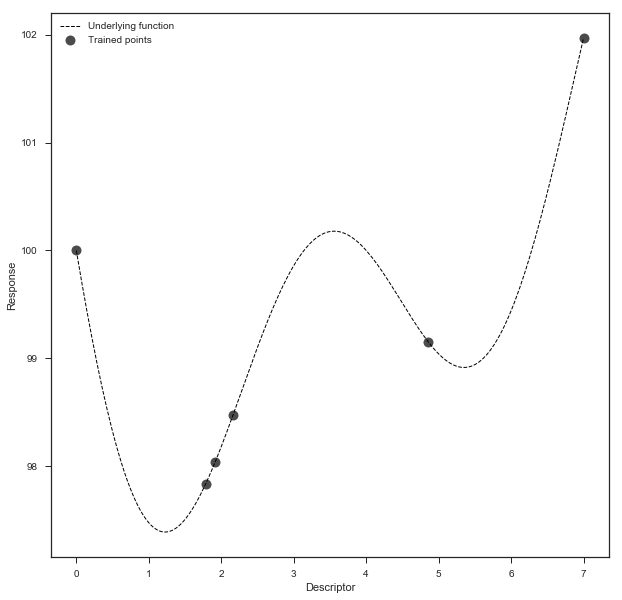

In [40]:
# Store the known underlying function for plotting.

linex = np.linspace(0.0, 7.0, test_points)
linex = np.reshape(linex, (1, np.shape(linex)[0]))
linex = np.sort(linex)
liney = []
for i in linex:
    liney.append(afunc(i)[0])

f, ax = plt.subplots(figsize=(10,10))    
    
ax.plot(linex[0], liney[0], '--', lw=1, color='black', label='Underlying function')

# Plot the train data (circles):
ax.plot(train, target, 'o', alpha=0.7, color='black', markersize=10, label='Trained points')

ax.set_xlabel('Descriptor')
ax.set_ylabel('Response')
ax.legend()

Compare the predicted mean (including uncertainty) obtained when not including first derivative observations in the trained model with the underlying "real" function.

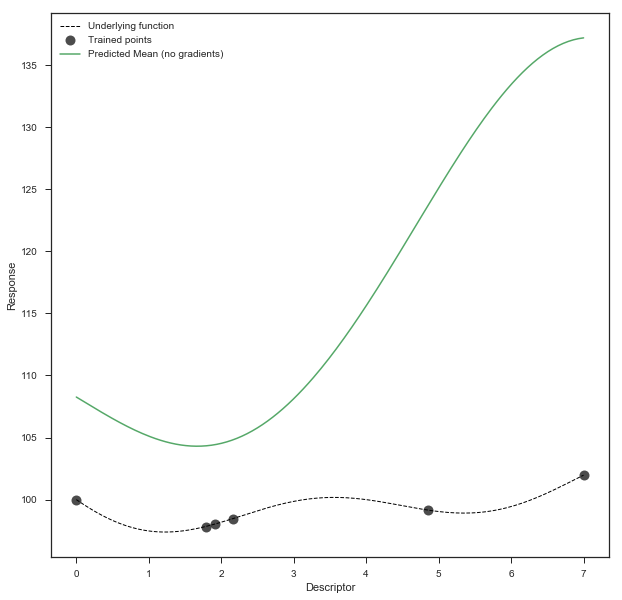

In [41]:
upper_no_grad = pred_mean_no_grad + uncertainty_no_grad
lower_no_grad = pred_mean_no_grad - uncertainty_no_grad

f, ax = plt.subplots(figsize=(10,10))   
ax.plot(linex[0], liney[0], '--', lw=1, color='black', label='Underlying function')
ax.plot(train, target, 'o', alpha=0.7, color='black', markersize=10, label='Trained points')
ax.plot(test, pred_mean_no_grad, 'g-', lw=1.5, alpha=1.0, label='Predicted Mean (no gradients)')
ax.fill_between(test[:, 0], upper_no_grad, lower_no_grad, interpolate=True, color='red',
                alpha=0.2)
ax.set_xlabel('Descriptor')
ax.set_ylabel('Response')
ax.legend()
plt.show()

Finally, compare the predicted mean (including uncertainty) obtained when including first derivative observations in the trained model with the underlying "real" function.



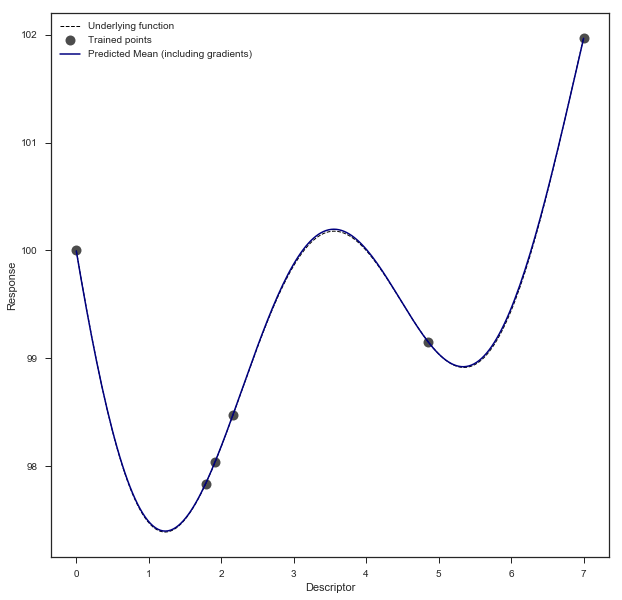

In [42]:
f, ax = plt.subplots(figsize=(10,10))   
ax.plot(linex[0], liney[0], '--', lw=1, color='black', label='Underlying function')
ax.plot(train, target, 'o', alpha=0.7, color='black', markersize=10, label='Trained points')
ax.plot(test, pred_mean_inc_grad, 'g-', lw=1.5, alpha=1.0, color='navy', label='Predicted Mean (including gradients)')
ax.set_xlabel('Descriptor')
ax.set_ylabel('Response')
ax.legend()
plt.show()